In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table
import numpy as np
import sys
# from biomed_utils import *
from scipy.stats import ttest_ind, ttest_1samp, ttest_rel
import statsmodels.stats.api as sms

/export/home/ylerner/.conda/envs/pyenv_ylerner/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
res = pd.read_csv('./results/all_cv.csv')


Load and reformat

In [4]:
def custom_agg3(series):
    mu = np.mean(series)
    mu = str(round(mu, 1))

    if len(series)>1:
        low, high = sms.DescrStatsW(series).tconfint_mean(alpha=0.05, alternative='two-sided')
        low = str(round(low, 1))
        high = str(round(high, 1))

        ci = mu + " [" + low + "-" + high + "]"
    else:
        ci = mu
    return ci

In [5]:
par = pd.read_csv('./results/partial_cv.csv', header=None)


parcol = ["Entity", "TP","FP","FN","Precision", "Recall","F-mesure", "Set", "Model", "Data"]

par.columns = parcol


par = par.replace({"Entity":{"DIAGNAME":"Disease or disorder",
                     "DIAGPROC":"Diagnostic procedure or test",
                     "MED":"Drug name",
                     "SIGNS":"Clinical sign or symptom",
                     "THERAPPROC":"Therapeuthic procedure",
                             "Overall":"All types"
                            
                    }
          })





nonexactter =  pd.read_csv('./results/nonexact.csv').loc[lambda x:x.Model.str.contains('Termi'),:]

nonexactter = (nonexactter.rename(columns={"Type":"Entity", "F1":"F-mesure"})
 .assign(Data = lambda x:x.Model.str.split(" ", expand=True).iloc[:,0])
 .assign(Model = lambda x:x.Model.str.split(" ", expand=True).iloc[:,1])
 .assign(Set ="TEST")

 .replace({"Entity":{"Overall":"All types", 
                     "Clinical sign":'Clinical sign or symptom', 
                     "Diagnostic proc.":'Diagnostic procedure or test', 
                     "Therapeuthic proc.":"Therapeuthic procedure"
                    }})
 .loc[:, par.columns]
)

par = pd.concat([nonexactter, par])

par.loc[:,["Precision","Recall","F-mesure"]] = par.loc[:,["Precision","Recall","F-mesure"]] * 100


dfpar= (par
 .loc[lambda x:~x.Model.str.contains('distant|fix')]
 .groupby(['Data', 'Entity',  'Model'])['F-mesure', 'Precision', 'Recall']
#  .agg({'T-test':list, 'Results':custom_agg2})
 .agg({'Results':custom_agg3})
 .round(1)
 .sort_values(["Entity","Model"])
)


/export/home/ylerner/.conda/envs/pyenv_ylerner/lib/python3.5/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [6]:
%%capture #warnings
res = pd.read_csv('./results/all_cv.csv')

res = res.rename(columns={"Entity type":"Entity"})

res = res.replace({"Entity":{"DIAGNAME":"Disease or disorder",
                     "DIAGPROC":"Diagnostic procedure or test",
                     "MED":"Drug name",
                     "SIGNS":"Clinical sign or symptom",
                     "THERAPPROC":"Therapeuthic procedure"
                    }
          })




df= (res
 .loc[lambda x:~x.Model.str.contains('distant|fix')]
 .groupby(['Data', 'Entity',  'Model'])['F-mesure', 'Precision', 'Recall']
#  .agg({'T-test':list, 'Results':custom_agg2})
 .agg({'Results':custom_agg3})

 .drop(("APHP-Med", "All types"))
 .round(1)
 .sort_values(["Entity","Model"])
)


# Table 1

In [7]:
table1 = df.loc[(["APHP-Med", "I2B2"], "Drug name", ["Terminologies", "Supervised", "Supervised_with_features", "Supervised-small", "Supervised_with_features", "Supervised-small_with_features"])].sort_values(['Data', 'Model'], ascending=False)


table1 = table1.reset_index()

# dfpar = dfpar.loc[:,['Data', 'Entity', 'Model', 'F-mesure', 'Precision', 'Recall']]

table1 = table1.merge(dfpar, on=['Data', 'Entity', 'Model'], how="left", suffixes=("_exact","_partial"))

table1.Model = table1.Model.astype('category')

table1.Model = table1.Model.cat.reorder_categories(['Terminologies', 'Supervised', 'Supervised_with_features', "Supervised-small",  "Supervised-small_with_features"])

table1.Data = table1.Data.astype('category')
table1.Data = table1.Data.cat.reorder_categories(['I2B2', 'APHP-Med'])

table1 = table1.sort_values(["Data", "Model"]).replace({"Model":{"Supervised":"biGRU-CRF", "Supervised_with_features":"Hybrid system"}}).drop(columns='Entity')
table1.columns = table1.columns.droplevel()


In [8]:
table1

F-mesure  \
0      I2B2                   Terminologies              73.0   
4      I2B2                       biGRU-CRF  91.1 [90.3-91.9]   
1      I2B2                   Hybrid system  92.2 [91.4-92.9]   
3      I2B2                Supervised-small  85.6 [84.8-86.3]   
2      I2B2  Supervised-small_with_features  87.8 [86.4-89.2]   
5  APHP-Med                   Terminologies              75.0   
7  APHP-Med                       biGRU-CRF  81.9 [81.2-82.6]   
6  APHP-Med                   Hybrid system  86.4 [86.1-86.7]   

          Precision            Recall          F-mesure         Precision  \
0              76.7              69.7              84.6              88.9   
4  90.6 [89.1-92.1]  91.7 [88.8-94.6]  93.5 [92.7-94.3]  92.9 [91.5-94.4]   
1  92.1 [91.4-92.9]  92.2 [90.5-93.9]  94.7 [94.1-95.2]  94.6 [94.0-95.3]   
3  85.2 [83.2-87.2]  86.0 [83.1-89.0]  90.4 [89.8-91.1]  90.1 [87.9-92.4]   
2  88.2 [87.0-89.4]  87.4 [84.6-90.3]  90.6 [86.7-94.6]  92.0 [90.7-93.3]   
5              70.8              79.7              77.7              73.3   
7  86.6 [84.8-88.3]  77.8 [76.3-79.2]  86.4 [85.3-87.6]  91.4 [89.8-92.9]   
6  89.6 [88.0-91.2]  83.4 [82.2-84.5]  90.4 [89.8-90.9]  93.8 [92.2-95.3]   

             Recall  
0              80.6  
4  94.2 [91.2-97.2]  
1  94.7 [93.1-96.3]  
3  90.8 [87.8-93.8]  
2  89.4 [82.5-96.4]  
5              82.5  
7  82.0 [80.0-84.1]  
6  87.2 [85.8-88.7]

# Table 2

In [9]:
table2 = df.loc[("APHP-All", slice(None), ["Terminologies", "Supervised", "Supervised_with_features"])].sort_values(['Entity', 'Model'])

#table2.columns = table2.columns.droplevel()

table2 = table2.reset_index()

table2 = table2.merge(dfpar, on=['Data', 'Entity', 'Model'], how="left", suffixes=("_exact","_partial"))

table2.Model = table2.Model.astype('category').cat.reorder_categories(['Terminologies', 'Supervised', 'Supervised_with_features'])

table2.Entity = table2.Entity.astype('category').cat.reorder_categories(['All types', 
                                                         'Drug name',
                                                
                                                         'Clinical sign or symptom',
                                                         'Disease or disorder', 

                                                         'Diagnostic procedure or test', 
                                                         'Therapeuthic procedure'])

table2 = table2.sort_values(["Entity", "Model"]).replace({"Model":{"Supervised":"biGRU-CRF", "Supervised_with_features":"Hybrid system"}})
table2.columns = table2.columns.droplevel()


In [10]:
table2

F-mesure  \
2   APHP-All                     All types  Terminologies              32.5   
0   APHP-All                     All types      biGRU-CRF  67.1 [66.6-67.5]   
1   APHP-All                     All types  Hybrid system  69.5 [69.2-69.8]   
14  APHP-All                     Drug name  Terminologies              75.0   
12  APHP-All                     Drug name      biGRU-CRF  81.5 [80.3-82.6]   
13  APHP-All                     Drug name  Hybrid system  85.9 [85.1-86.6]   
5   APHP-All      Clinical sign or symptom  Terminologies              15.7   
3   APHP-All      Clinical sign or symptom      biGRU-CRF  55.2 [53.9-56.5]   
4   APHP-All      Clinical sign or symptom  Hybrid system  59.9 [59.6-60.1]   
11  APHP-All           Disease or disorder  Terminologies              30.9   
9   APHP-All           Disease or disorder      biGRU-CRF  59.5 [58.4-60.7]   
10  APHP-All           Disease or disorder  Hybrid system  62.4 [61.5-63.3]   
8   APHP-All  Diagnostic procedure or test  Terminologies              30.4   
6   APHP-All  Diagnostic procedure or test      biGRU-CRF  75.9 [75.3-76.6]   
7   APHP-All  Diagnostic procedure or test  Hybrid system  77.7 [77.5-77.8]   
17  APHP-All        Therapeuthic procedure  Terminologies              16.6   
15  APHP-All        Therapeuthic procedure      biGRU-CRF  61.3 [60.9-61.7]   
16  APHP-All        Therapeuthic procedure  Hybrid system  60.2 [59.6-60.8]   

           Precision            Recall          F-mesure         Precision  \
2               49.2              24.3              48.4              73.5   
0   69.1 [68.5-69.6]  65.2 [64.4-65.9]  82.9 [82.7-83.1]  85.0 [84.2-85.8]   
1   71.6 [70.9-72.3]  67.5 [66.9-68.0]  84.1 [84.0-84.3]  86.3 [85.7-86.8]   
14              70.8              79.7              77.7              73.3   
12  84.6 [81.9-87.3]  78.6 [77.8-79.4]  85.9 [85.1-86.6]  89.2 [86.7-91.7]   
13  87.3 [86.4-88.2]  84.5 [83.5-85.4]  90.4 [89.8-91.1]  92.0 [91.0-93.0]   
5               38.9               9.8              28.4              70.4   
3   56.6 [55.4-57.7]  53.8 [51.4-56.3]  76.5 [75.6-77.4]  77.4 [76.1-78.7]   
4   61.6 [59.8-63.3]  58.3 [57.0-59.6]  78.8 [78.2-79.4]  80.3 [78.5-82.2]   
11              33.3              28.9              62.5              68.1   
9   61.9 [60.4-63.3]  57.4 [56.4-58.3]  79.4 [78.9-80.0]  82.2 [81.4-83.0]   
10  64.5 [63.5-65.5]  60.4 [59.5-61.4]  80.9 [80.7-81.1]  83.1 [82.9-83.3]   
8               61.4              20.2              40.1              81.3   
6   77.1 [76.3-77.9]  74.8 [74.1-75.5]  88.0 [87.6-88.5]  89.2 [88.4-89.9]   
7   79.0 [78.5-79.4]  76.4 [76.0-76.8]  88.5 [88.3-88.7]  89.8 [89.4-90.1]   
17              36.1              10.8              35.1              76.6   
15  64.4 [63.0-65.8]  58.5 [57.6-59.5]  80.9 [80.6-81.3]  84.6 [82.9-86.3]   
16  64.4 [62.9-66.0]  56.5 [55.0-58.0]  80.1 [79.6-80.7]  85.1 [83.3-87.0]   

              Recall  
2               36.1  
0   80.9 [80.6-81.3]  
1   82.1 [81.4-82.8]  
14              82.5  
12  82.8 [81.9-83.8]  
13  89.0 [88.1-89.8]  
5               17.8  
3   75.6 [73.4-77.8]  
4   77.4 [75.5-79.4]  
11              57.8  
9   76.9 [76.1-77.7]  
10  78.8 [78.2-79.3]  
8               26.6  
6   86.9 [86.4-87.5]  
7   87.3 [86.8-87.7]  
17              22.8  
15  77.5 [76.4-78.7]  
16  75.7 [73.7-77.7]

## R kernel - Fig 3

In [1]:
require(ggplot2)

Loading required package: ggplot2


In [2]:
fig1 <- read.csv("./results/fig1.csv")

In [3]:
fig1

Entity                       fmu_Hybrid.system fmu_Terminologies
1 All types                    69.5              32.5             
2 Drug name                    85.9              75.0             
3 Clinical sign or symptom     59.9              15.7             
4 Disease or disorder          62.4              30.9             
5 Diagnostic procedure or test 77.7              30.4             
6 Therapeuthic procedure       60.2              16.6             
  fmu_biGRU.CRF fsig_Hybrid.system fsig_biGRU.CRF
1 67.1          0.21               0.31          
2 81.5          0.55               0.82          
3 55.2          0.18               0.93          
4 59.5          0.66               0.83          
5 75.9          0.09               0.46          
6 61.3          0.41               0.31

In [4]:
fig1$n_entities <- c(4835,1074, 432, 1672, 1156, 501)

fig1$cooc <- c(6, 4, 15, 2, 8, 1)



Saving 6.67 x 6.67 in image


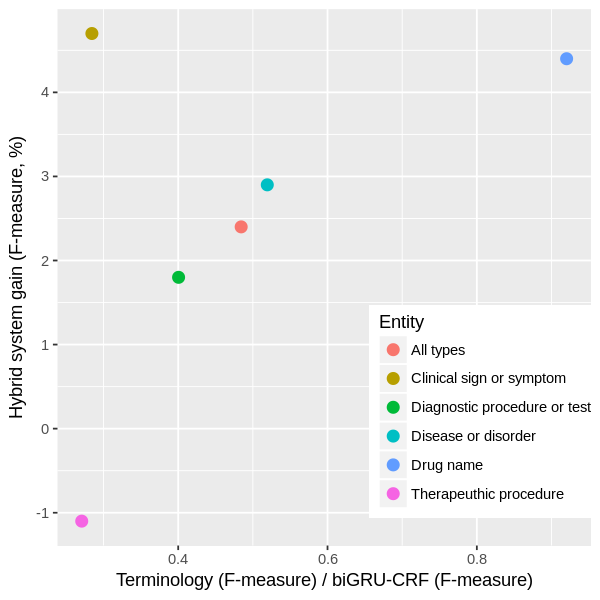

In [10]:
options(repr.plot.width=5, repr.plot.height=5)
ggplot(fig1, aes(x = (fmu_Terminologies / fmu_biGRU.CRF), y = fmu_Hybrid.system - fmu_biGRU.CRF)) + 
  geom_point(aes(color = Entity),  size=3)  + theme( legend.position=c(0.8,0.25))  + xlab("Terminology (F-measure) / biGRU-CRF (F-measure)")  + ylab("Hybrid system gain (F-measure, %)")

ggsave("results/medical_NER_fig3.pdf")

## Terminologies description

### French terminologies

|Terminologie source | Number of terms | 
|--- | --- | 
| ATC |          3509 | 
| BPDM |       10059 |
| CCAM  |       6227 |
| CIM-10    |     12761 |
| CLADIMED |    4016 |
| DRC     |      448 |
| GLIMS    |    1690 |
| NABM     |    1005 |
| QDOC      |   4702 |
| SNOWMED   |  42212 |
| UMLS      |  99028 |




|Semantic type | Number of terms | 
|--- | --- | 
| Anatomy       |  8782
| Disease or disorder     | 104104
| Diagnostic procedure     |  15025
| Medical devices      |  5349
| Laboratory or test results   |  1949
| Drug name           | 24932
| Clinical sign or symptoms         |  5125
| Therapeutic procedure   | 20926
| Unit          |  1414

### English terminologies

UMLS (+ snowmed) : 96547


## Dataset description

**I2B2 dataset** 

Discharge summary.



**APHP dataset**:  
147 documents. 

Various documents types:
- discharge summary
- letters
- surgery
- complementary exams

**APHP document types**:   

LT-AUTR  
CRH-J  
LT-CONS  
CRH-PEDIA  
CR-CONS  
LT-CONS-S  
CRH-S  
CR-URGE  
CRIOA  
DOC-EVOL  
LT-CRT  
CR-FIBR  
CRH-ORTHO  
CRH-CHIR  
CR-NUTRI-I  
CR-BRON  
CRSTAFF  
CR-BPREOPER  
LT-CONS-I  
CRH-HOSPI  
CR-CORO  
CR-COLO  
CR-OPER  
CRH-NEONAT  
LT-CRH  
CRH-EVOL  
CR-NUTRI  
CR-ENDO  
CRH-EEG  
CRH-HEMATO  
CRH-LT-SOR  
CR-BPOS

**Annotators agreement before harmonization with CRF**  

| Entity                       | Non exact F-mesure         |    Exact F-mesure   |
| ------------| ------------| -----------|
| Disease or disorder          | 0.77                       | 0.65   |
| Diagnostic procedure         | 0.87                       | 0.70   |
| Drug name                    | 0.92                       | 0.85   |
| Clinical signs or symptoms   | 0.71                       | 0.55   |
| Therapeutic procedure        | 0.71                       | 0.51   |

In [2]:
compute_corpus_stats_on_conll("../data/conll/aphp_auto_all_folds.txt")

{'median_tok_per_sent': 14.0,
 'n_bigram': {'DIAGNAME': 330,
  'DIAGPROC': 297,
  'MED': 54,
  'SIGNS': 65,
  'THERAPPROC': 73},
 'n_ent': 4837,
 'n_ent_types': {'DIAGNAME': 1672,
  'DIAGPROC': 1156,
  'MED': 1076,
  'SIGNS': 432,
  'THERAPPROC': 501},
 'n_sent': 3093,
 'n_tok': 80421,
 'n_trigramplus': {'DIAGNAME': 104,
  'DIAGPROC': 51,
  'MED': 8,
  'SIGNS': 11,
  'THERAPPROC': 14},
 'n_unigram': {'DIAGNAME': 1238,
  'DIAGPROC': 808,
  'MED': 1014,
  'SIGNS': 356,
  'THERAPPROC': 414},
 'n_voc': 12523}

In [9]:
#write all
with open("../data/conll/i2b2_2009_gold_test.txt", "r") as h :
    txt1 = h.read()

with open("../data/conll/i2b2_2009_gold_train.txt", "r") as h :
    txt2 = h.read()

with open("../data/conll/i2b2_2009_gold_dev.txt", "r") as h :
    txt3 = h.read()

txt = txt1  +"\n"+ txt2 +"\n"+ txt3

with open("../data/conll/i2b2_2009_gold_all.txt", "w") as h :
    h.write(txt)

In [10]:
compute_corpus_stats_on_conll("../data/conll/i2b2_2009_gold_all.txt")

{'median_tok_per_sent': 13.0,
 'n_bigram': {'MED': 1056},
 'n_ent': 8573,
 'n_ent_types': {'MED': 8573},
 'n_sent': 17933,
 'n_tok': 337745,
 'n_trigramplus': {'MED': 1029},
 'n_unigram': {'MED': 6488},
 'n_voc': 23214}